In [1]:
import warnings
import random
from pathlib import Path
from collections import defaultdict

import GEOparse
from GEOparse.GEOparse import GSE, GSM
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ignore warnings
warnings.filterwarnings("ignore")

# Show all columns
pd.set_option('display.max_columns', None)

# DNA methylation age of human tissues and cell types (Steve Horvath)

https://link.springer.com/article/10.1186/gb-2013-14-10-r115#Sec40

# 0. Datasets Matedata Analysis

In [2]:
url = "https://static-content.springer.com/esm/art%3A10.1186%2Fgb-2013-14-10-r115/MediaObjects/13059_2013_3156_MOESM1_ESM.csv"
dataset_meta = pd.read_csv(url, encoding="latin1")
dataset_meta["Availability"] = dataset_meta["Availability"].str.strip()
dataset_meta

,Data label (color),DNA origin,Platform,Data Use,n (Prop.Female),Median Age(range),Citation,Availability,"Cor(Age,m.age(Train.CpGs))","Median error (Age, m.age(Train.CpGs))",Median AgeAcceleration(Train.CpGs),Cor LOOCV,Error LOOCV
0,1 (turquoise),Blood WB,27K,Training,715 (0.38),"33 (16,88)",Horvath 2012,GSE41037,0.96,2.8,-0.1,0.95 (0),3.2
1,2 (blue),Blood WB,450K,Training,94 (0.28),"29 (18,65)",Horvath 2012,GSE41169,0.93,2.5,0.7,0.92 (0),2.7
2,3 (brown),Blood WB,450K,Training,656 (0.52),"65 (19,100)",Hannum 2012,GSE40279,0.91,3.9,-0.7,0.88 (0),8.9
3,4 (blue2),Blood PBMC,450K,Training,72 (0),"3.1 (1,16)",Alisch 2012,GSE36064,0.96,0.5,0.3,0.96 (0),0.8
4,5 (green),Blood PBMC,450K,Training,48 (0.52),"15 (3.5,76)",Harris et al 2012,GSE32149,0.96,2.4,-0.5,0.95 (0),1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,Stem cells+Somatic Cells,450K,Other,153 (0.63),NaN,Nazor 2012,GSE31848,NaN,NaN,NaN,NaN,NaN
78,79,Reprogrammed mesenchymal stromal cells,450K,Other,24 (NA),NaN,Shao 2012,GSE37066,NaN,NaN,NaN,NaN,NaN
79,80,HematopoieticStemAndNormalPrimaryTissue,27k,Other,34 (NA),NaN,Calvanese 2012,GSE30090,NaN,NaN,NaN,NaN,NaN
80,81,hESC,27k,Other,6 (NA),NaN,Ramos-Mejía 2012,GSE30456,NaN,NaN,NaN,NaN,NaN


In [3]:
dataset_meta['DNA origin'].value_counts()

DNA origin
Blood WB                                      8
Blood PBMC                                    5
Blood Cord                                    4
Buccal                                        4
Lung NL Adj                                   4
Kidney                                        3
Colon                                         3
Saliva                                        3
Breast NL Adj                                 2
Blood Cell Types                              2
Prostate NL                                   2
Placenta                                      2
Heart                                         2
Brain CRBLM                                   2
Sperm                                         2
Muscle                                        2
Stem cells+Somatic Cells                      2
Epidermis                                     1
Breast NL                                     1
BrainVariousCells                             1
Brain TCTX                   

In [4]:
dataset_meta['Platform'].value_counts()

Platform
27K     49
450K    26
27k      4
450k     3
Name: count, dtype: int64

In [5]:
dataset_meta['Data Use'].value_counts()

Data Use
Training    39
Test        32
Other       11
Name: count, dtype: int64

# 1. GEO Data Analysis

In [6]:
GEO_DATA_DIR = Path("./data/GEO/")

gse_set = sorted(dataset_meta.loc[dataset_meta["Availability"].str.contains("GSE"), "Availability"].unique())

# Show chunks of 3
for i in range(0, len(gse_set), 3):
    print(gse_set[i:i + 3])

['GSE15745', 'GSE17448', 'GSE19711']
['GSE20067', 'GSE20236', 'GSE20242']
['GSE22595', 'GSE25892', 'GSE26033']
['GSE26126', 'GSE26974', 'GSE27097']
['GSE27317', 'GSE28746', 'GSE30090']
['GSE30456', 'GSE30601', 'GSE30653']
['GSE30758', 'GSE30870', 'GSE31848']
['GSE32146', 'GSE32149', 'GSE32393']
['GSE34035', 'GSE34257', 'GSE34639']
['GSE35069', 'GSE36064', 'GSE36166']
['GSE36642', 'GSE36812', 'GSE37008']
['GSE37066', 'GSE37988', 'GSE38291']
['GSE38608', 'GSE38873', 'GSE40279']
['GSE40700', 'GSE41037', 'GSE41169']
['GSE41782', 'GSE41826', 'GSE42510']
['GSE42700', 'GSE42861', 'GSE42865']
['GSE43269', 'GSE44667', 'GSE47627']


In [7]:
SAMPLES = defaultdict(dict)
SAMPLES_CELLS = defaultdict(dict)

ARRAY_PATHS = {
    27578: Path('./data/arrays_27k'),
    485577: Path('./data/arrays_450k')
}
CELLS_PATHS = {
    27578: Path('./data/arrays_27k_cells'),
    485577: Path('./data/arrays_450k_cells')
}

for path in (list(ARRAY_PATHS.values()) + list(CELLS_PATHS.values())):
    path.mkdir(parents=True, exist_ok=True)


def get_gse(gse_id):
    return GEOparse.get_GEO(gse_id, destdir=str(GEO_DATA_DIR), silent=True)


def plot_age_ditribution(gse_id):
    if len(SAMPLES[gse_id]) == 0:
        print(f"The length of {gse_id} is 0")
        return
    ages = pd.DataFrame(SAMPLES[gse_id]).T["age"].dropna().astype(int)
    plt.figure(figsize=(5, 2))
    sns.histplot(ages, bins=20)
    plt.title("Age distribution")
    plt.show()


def remove_gse(gse_id):
    (GEO_DATA_DIR / f'{gse_id}_family.soft.gz').unlink(missing_ok=True)


def get_platform(gse_id):
    return dataset_meta.loc[dataset_meta["Availability"] == gse_id, "Platform"].iloc[0].lower()


def is_correct_array(gsm: GSM):
    return len(gsm.table) in ARRAY_PATHS


def save_array(gsm_name, gsm_table, path_dict):
    array_length = len(gsm_table)
    if array_length in path_dict:
        array = np.array(gsm_table.sort_values(by='ID_REF')['VALUE'])
        np.save(path_dict[array_length] / f'{gsm_name}.npy', array)


def array_save(gsm_name: str, gsm: GSM):
    save_array(gsm_name, gsm.table, ARRAY_PATHS)

def array_cells_save(gsm_name: str, gsm: GSM):
    save_array(gsm_name, gsm.table, CELLS_PATHS)

def sample_meta_parse(metadata: dict):
    sample_meta = {}
    for x in metadata['characteristics_ch1']:
        values = x.split(": ")
        sample_meta[values[0]] = values[1] if len(values) == 2 else None
    return sample_meta

## 1.1. GSE15745

**Abundant Quantitative Trait Loci for CpG Methylation and Expression Across Human Brain Tissues**

Because of our interest in genomic regulation of expression and neurological disorders we embarked upon a series of experiments to provide a brain region-specific contextual framework for genetic and epigenetic regulation of gene expression. We obtained frozen brain tissue from the cerebellum, frontal cortex, pons and temporal cortex from 150 subjects (total 600 tissue samples). We undertook four separate assays across this series; first, genome-wide SNP genotyping; second, assay of >27,000 CpG methylation sites in each of the four brain regions; third, mRNA expression profiling of >22,000 transcripts in all four brain regions; and, fourth, miRNA expression profiling of 735 miRNA transcripts. Here we discuss the results of these experiments, particularly in the context of integrated datasets to define expression and CpG methylation quantitative trait loci (eQTL and methQTL) and detailing differences and similarities across brain regions.

In [8]:
CURRENT_GSE = "GSE15745"
gse = get_gse(CURRENT_GSE)

In [9]:
list(gse.phenotype_data['characteristics_ch1.5.tissue'].unique())

['cerebellum', 'frontal cortex', 'pons', 'temporal cortex', nan]

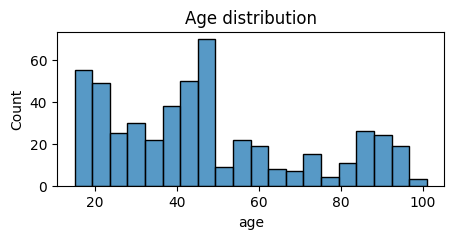

In [10]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    gsm_metadata = gsm.metadata
    sample_meta = sample_meta_parse(gsm_metadata)

    if gsm_metadata['molecule_ch1'][0] != 'genomic DNA':
        continue
    
    if pd.isna(sample_meta['tissue'][0]):
        continue

    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta.get('age') or sample_meta.get('age (y)')),
        'tissue': 'brain',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.2. GSE17448

**Methylation Pattern of Human Mesenchymal Stromal Cells**

In this study, we have analyzed DNA methylation changes upon long-term culture and aging of MSC by using the HumanMethylation27 BeadChip assessing 27,578 unique CpG sites. Cells were taken from bone marrow aspirates from iliac crest (BM) of healthy donors or from the caput femoris (HIP) of elderly patients that received femoral head prosthesis.Overall, the methylation pattern was maintained throughout both long-term culture and aging but highly significant differences were observed at specific CpG sites. Notably, methylation changes in MSC were related in long-term culture and aging in vivo.

In [11]:
CURRENT_GSE = "GSE17448"
gse = get_gse(CURRENT_GSE)

In [12]:
list(gse.phenotype_data['characteristics_ch1.0.cell type'].unique())

['mesenchymal stromal cells from human bone marrow']

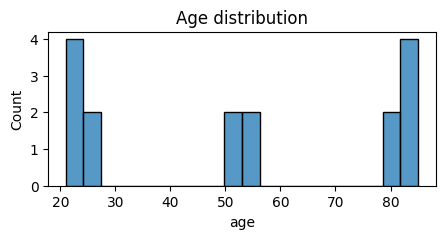

In [13]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': None,
        'age': int(sample_meta['age'].split()[0]),
        'tissue': 'bone marrow',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.3. GSE19711

**Genome wide DNA methylation profiling of United Kingdom Ovarian Cancer Population Study (UKOPS)**

The Illumina Infinium 27k Human DNA methylation Beadchip v1.2 was used to obtain DNA methylation profiles across approximately 27,000 CpGs in whole blood samples from 540 samples, of which 266 were samples taken from postmenopausal women with ovarian cancer and 274 were from age-matched healthy controls

In [14]:
CURRENT_GSE = "GSE19711"
gse = get_gse(CURRENT_GSE)

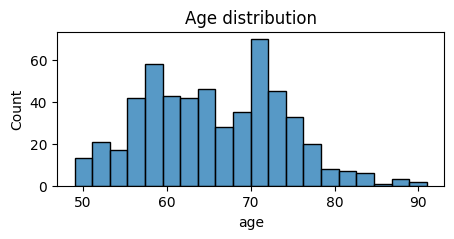

In [15]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    is_cancer = sample_meta['pre-treatment sample'] == 'No' and sample_meta['post-treatment sample'] == 'No'
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'female',
        'age': int(sample_meta['ageatrecruitment']),
        'tissue': 'blood',
        'disease': 'cancer' if is_cancer else 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.4. GSE20067

**Genome wide DNA methylation profiling of diabetic nephropathy in type 1 diabetes mellitus**

The Illumina Infinium 27k Human DNA methylation Beadchip v1.2 was used to obtain DNA methylation profiles across approximately 27,000 CpGs in whole blood samples from a case-control study of 192 Irish patients with type 1 diabetes mellitus (T1D). Cases had T1D and nephropathy whereas controls had T1D but no evidence of renal disease.

In [16]:
CURRENT_GSE = "GSE20067"
gse = get_gse(CURRENT_GSE)

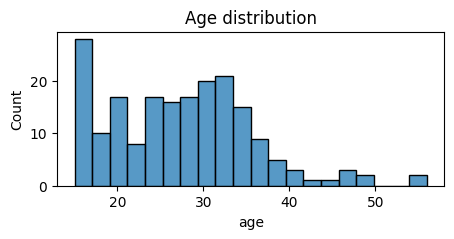

In [17]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['sex'].lower(),
        'age': int(sample_meta['durationt1d']),
        'tissue': 'blood',
        'disease': 'diabetes I',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.5. GSE20236

**Human Aging-associated DNA Hypermethylation Occurs Preferentially at Bivalent Chromatin Domains**

There is a growing realization that some aging-associated phenotypes/diseases have an epigenetic basis. Here we report the first genome-scale study of epigenomic dynamics during normal human aging. We identify aging-associated differentially methylated regions (aDMRs) in whole blood in a discovery cohort, and then replicate these aDMRs in sorted CD4+ T-cells and CD14+ monocytes in an independent cohort, suggesting that aDMRs occur in precursor haematopoietic cells. Further replication of the aDMRs in buccal cells, representing a tissue that originates from a different germ-layer compared with blood, demonstrates that the aDMR signature is a multi-tissue phenomenon. Moreover, we demonstrate that aging-associated DNA hypermethylation occurs predominantly at bivalent chromatin domain promoters. This same category of promoters, associated with key developmental genes, is frequently hypermethylated in cancers and in vitro cell culture, pointing to a novel mechanistic link between aberrant hypermethylation in cancer, aging, and cell culture.

We measured the methylation state of 27,578 CpG sites (Illumina HumanMethylation27 array) in whole blood samples from 93 heathy human females aged between 49 and 74, to discover sites which change methylation state with age.

In [18]:
CURRENT_GSE = "GSE20236"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(float(sample_meta['age'].split(' ')[0])),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE20236 is 0


## 1.6. GSE20242

**Human Aging-associated DNA Hypermethylation Occurs Preferentially at Bivalent Chromatin Domains**

There is a growing realization that some aging-associated phenotypes/diseases have an epigenetic basis. Here we report the first genome-scale study of epigenomic dynamics during normal human aging. We identify aging-associated differentially methylated regions (aDMRs) in whole blood in a discovery cohort, and then replicate these aDMRs in sorted CD4+ T-cells and CD14+ monocytes in an independent cohort, suggesting that aDMRs occur in precursor haematopoietic cells. Further replication of the aDMRs in buccal cells, representing a tissue that originates from a different germ-layer compared with blood, demonstrates that the aDMR signature is a multi-tissue phenomenon. Moreover, we demonstrate that aging-associated DNA hypermethylation occurs predominantly at bivalent chromatin domain promoters. This same category of promoters, associated with key developmental genes, is frequently hypermethylated in cancers and in vitro cell culture, pointing to a novel mechanistic link between aberrant hypermethylation in cancer, aging, and cell culture.

We measured the methylation state of 27,578 CpG sites (Illumina HumanMethylation27 array) in sorted human blood cells to validate aging-associated DMRs.

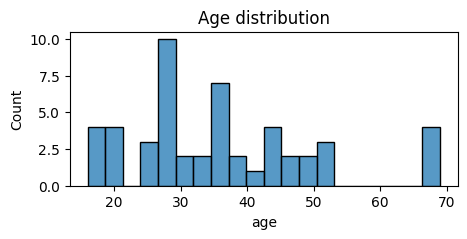

In [19]:
CURRENT_GSE = "GSE20242"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['sex'].lower(),
        'age': int(sample_meta['age']),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.7. GSE22595

**Methylation Pattern of Human Dermal Fibroblasts**

In this study, we have analyzed DNA methylation changes upon aging of human dermal fibroblasts by using the HumanMethylation27 BeadChip assessing 27,578 unique CpG sites. Cells were isolated from skin samples donated by young (6-23 years) and elderly (60-73 years) patients undergoing surgical interventions. Strikingly, global DNA-methylation profiles of fibroblasts from the same anatomical site clustered closely together indicating that fibroblasts maintain positional memory even after in vitro culture.

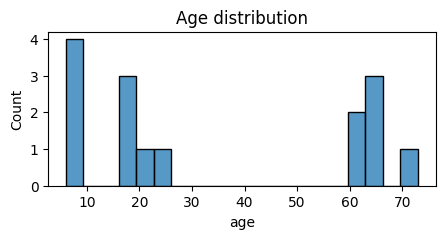

In [20]:
CURRENT_GSE = "GSE22595"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': None,
        'age': int(sample_meta['age'].split(' ')[0]),
        'tissue': 'skin',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.8. GSE25892

**Epigenetic Vestiges of Early Developmental Adversity: Child Stress Exposure and Adolescent DNA Methylation**

Fifteen-year-old adolescents (N = 109) in a longitudinal study of child development were recruited to examine differences in DNA methylation in relation to parent reports of adversity during the adolescents’ infancy and preschool periods. Microarray technology applied to 28,000 cytosine–guanine dinucleotide sites within DNA derived from buccal epithelial cells showed differential methylation among adolescents whose parents reported high levels of stress during their children’s early lives. Maternal stressors in infancy and paternal stressors in the preschool years were most strongly predictive of differential methylation, and the patterning of such epigenetic marks varied by children’s gender. To the authors’ knowledge, this is the first report of prospective associations between adversities in early childhood and the epigenetic conformation of adolescents’ genomic DNA.

In [21]:
CURRENT_GSE = "GSE25892"
gse = get_gse(CURRENT_GSE)

In [22]:
list(gse.phenotype_data['characteristics_ch1.6.tissue'].unique())

['bucca']

In [23]:


platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['age'].split(' ')[0]),
        'tissue': 'skin',
        'disease': 'healthy',
        'platform': platform,
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE25892 is 0


## 1.9. GSE26033 (NO AGE)

**A Genome-wide Study of DNA Methylation Patterns and Gene Expression Levels in Multiple Human and Chimpanzee Tissues**

It has long been hypothesized that changes in gene regulation have played an important role in primate evolution. However, despite the wealth of comparative gene expression data, there are still only few studies that focus on the mechanisms underlying inter-primate differences in gene regulation. In particular, we know relatively little about the degree to which changes in epigenetic profiles might explain differences in gene expression levels between primates. To this end, we studied DNA methylation and gene expression levels in livers, hearts, and kidneys from multiple humans and chimpanzees.

Genome wide DNA methylation profiling of heart, kidney, and liver samples from humans and chimpanzees. The Illumina Infinium 27K Human DNA Methylation BeadChip v1.2 was used to compare DNA methylation profiles across approximately 10,575 CpG sites in human and chimpanzee tissue samples. Samples included 6 human livers, 6 human kidneys, 6 human heart, 6 chimpanzee livers, 6 chimpanzee kidneys, and 6 chimpanzee hearts. Two techical replicates of bisulfite converted DNA from each of the 36 samples was hybridized to the Illumina HumanMethylation27 Beadchip. We limited our analysis to the 10,575 probes that were a perfect sequence match to both the human and chimpanzee genomes and which were associated with genes for which we had previously collected expression measurements across the three tissues.


## 1.10. GSE26126

**DNA methylation profiling reveals novel biomarkers and important roles for DNA methyltransferases in prostate cancer**

Genome wide DNA methylation profiling of normal and tumor prostate samples, as well as cultured primary prostate cells overexpressing DNA Methyltransferases (DNMTs) and EZH2
Candidate gene based studies have identified a handful of aberrant CpG DNA methylation events in prostate cancer. However, DNA methylation profiles have not been compared on a large scale between prostate tumor and normal prostate, and the mechanisms behind these alterations are unknown. In this study, we quantitatively profiled 95 primary prostate tumors and 86 healthy prostate tissue samples for their DNA methylation levels at 26,333 CpGs representing 14,104 gene promoters by using the Illumina HumanMethylation27 platform. A 2-class Significance Analysis of this dataset revealed 5,912 CpG sites with increased DNA methylation and 2,151 CpG sites with decreased DNA methylation in tumors (FDR < 0.8%). Prediction Analysis of this dataset identified 87 CpGs that are the most predictive diagnostic methylation biomarkers of prostate cancer. By integrating available clinical follow-up data, we also identified 69 prognostic DNA methylation alterations that correlate with biochemical recurrence of the tumor. To identify the mechanisms responsible for these genome-wide DNA methylation alterations, we measured the gene expression levels of several DNA methyltransferases (DNMTs) and their interacting proteins by TaqMan qPCR and observed increased expression of DNMT3A2, DNMT3B, and EZH2 in tumors. Subsequent transient transfection assays in cultured primary prostate cells revealed that DNMT3B1 and DNMT3B2 overexpression resulted in increased methylation of a substantial subset of CpG sites that also showed tumor-specific increased methylation.

Bisulfite converted DNA from 193 samples were hybridized to the Illumina Infinium 27k Human Methylation Beadchip v1.2.
The tissue samples (first 181) and the cultured cell samples (last 12) were normalized independently.

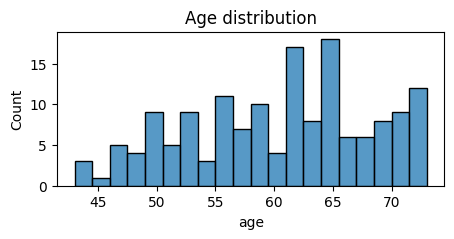

In [24]:
CURRENT_GSE = "GSE26126"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    if sample_meta.get('age') is None:
        continue
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['age'].split(' ')[0]),
        'tissue': 'prostate',
        'disease': 'healthy' if sample_meta['disease state'] == 'Normal' else 'cancer',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.11. GSE26974 (NO AGE)

**Sperm DNA methylation**

Sperm DNA and mRNA were isolated from 21 men with a range of semen parameters presenting to a tertiary male reproductive health clinic. DNA methylation was measured with the Illumina Infinium array at 27,000 CpG loci. Unsupervised clustering of methylation data differentiated the 21 sperm samples by their motility values.


## 1.12. GSE27097

**Pediatric age-associated DNA methylation**

DNA methylation (DNAm) plays diverse roles in human biology, but this dynamic epigenetic mark remains far from fully characterized. Although earlier studies uncovered loci that undergo age-associated DNAm changes in adults, little is known about such changes during childhood. Despite profound DNAm plasticity during embryogenesis and early development, monozygotic twins show indistinguishable childhood methylation, suggesting DNAm is highly coordinated during the pediatric period. Here we examine the methylation of 27,578 CpG dinucleotides in peripheral blood DNA from 398 boys, aged 3 to 17 years, and find significant age-associated changes in DNAm at 2,078 loci. We report a deficit of such loci on the X chromosome, a preference for specific nucleotides immediately surrounding the interrogated CpG dinucleotide, and a primary association with developmental and immune ontological functions. These pediatric age-associated loci overlap significantly with those previously identified in adults (p < 0.001) but most of the pediatric loci are unique, suggesting many are childhood-specific. Meta-analysis (n = 1080) with two adult studies reveals that the methylation changes in 29.5% of the age-associated pediatric loci follow a linear pattern from childhood into adulthood; however, we also find a three-fold higher rate of change in children compared with adults and that a higher proportion of lifelong changes are more accurately modeled as a function of logarithmic age. We therefore conclude that DNAm changes occur more rapidly during childhood and are imperfectly accounted for by statistical corrections that are linear in age, further suggesting that future DNAm studies are matched closely for age.

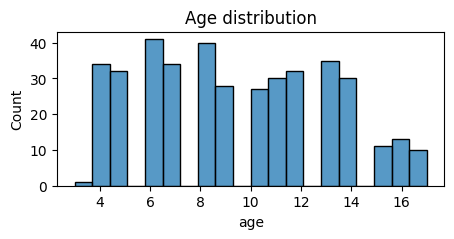

In [25]:
CURRENT_GSE = "GSE27097"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    age = sample_meta.get('age at collection (months)')
    if age is None:
        continue
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['age at collection (months)']) // 12,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.13. GSE27317

**Correlation between maternal age and newborn DNA methylation**

Using a genome-wide survey of 27,578 CpG dinucleotides in a cohort of 168 newborns, we examined the relationship between DNA methylation in newborns and a variety of parental and newborn traits. We found that methylation levels of 144 CpGs belonging to 142 genes were significantly correlated with maternal age. A weaker correlation was observed with paternal age. Among these genes, processes related to cancer were over-represented, as were functions related to neurological regulation, glucose/carbohydrate metabolism, nucleocytoplasmic transport, and transcriptional regulation. CpGs exhibiting gender differences in methylation were overwhelmingly located on the X chromosome, although a small subset of autosomal CpGs were found in genes previously shown to exhibit gender-specific differences in methylation levels. Conclusions: These results indicate that there are differences in CpG methylation levels at birth that are related to parental age and that could influence disease risk in childhood and throughout life.

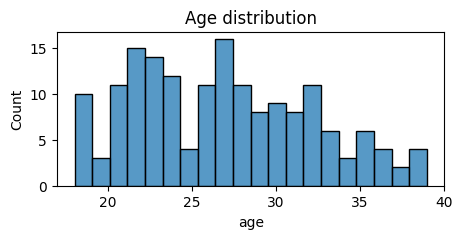

In [26]:
CURRENT_GSE = "GSE27317"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['maternal age (year)']),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.14. GSE28746

**Epigenome analysis of male identical twin pairs discordant for sexual orientation, age 21 to 55**

Genome wide DNA methylation profiling of saliva samples from male identical twins discordant for sexual orientation, age 21 to 55. The Illumina Infinium 27k Human DNA methylation Beadchip v1.2 was used to obtain DNA methylation profiles across approximately 27,000 CpGs in bisulfite converted DNA. Samples included 34 pairs of identical twins and one set of identical triplets, and 13 hybridisations were technical replicates of a selection of those samples.


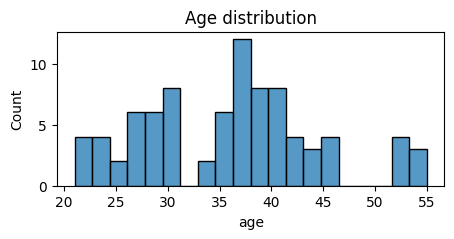

In [27]:
CURRENT_GSE = "GSE28746"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)
    
    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'male',
        'age': int(sample_meta['age']),
        'tissue': 'saliva',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.15. GSE30090 (CELLS)

**A promoter DNA demethylation landscape of human hematopoietic differentiation**

Global mechanisms defining the gene expression programs specific for hematopoiesis are still not fully understood. Here, we show that promoter DNA demethylation is associated the activation of hematopoietic-specific genes. Using genome-wide promoter methylation arrays, we identified 694 hematopoietic-specific genes repressed by promoter DNA methylation in human ESCs and whose loss of methylation in hematopoietic can be associated with gene expression. The association between promoter methylation and gene expression was studied for many hematopoietic-specific genes including CD45, CD34, CD28, CD19, the T cell receptor (TCR), the MHC class II gene HLA-DR, perforin 1, and the phosphoinositide 3-kinase (PI3K) and results indicated that DNA demethylation was not always sufficient for gene activation. Promoter demethylation occurred either early during embryonic development or later on during hematopoietic differentiation. Analysis of the genome-wide promoter methylation status of induced pluripotent stem cells (iPSCs) generated from somatic CD34+ HSPCs and differentiated derivatives from CD34+ HSPCs confirmed the role of DNA methylation in regulating the expression of genes of the hemato-immune system, and indicated that promoter methylation of these genes may be associated to stemness. Together, these data suggest that promoter DNA demethylation might play a role in the tissue/cell-specific genome-wide gene regulation within the hematopoietic compartment.


In [8]:
CURRENT_GSE = "GSE30090"
gse = get_gse(CURRENT_GSE)

In [9]:
gse.phenotype_data['source_name_ch1'].value_counts()

source_name_ch1
human embryonic stem cell                    10
colon normal tissue                           2
bone normal tissue                            2
fat primary tissue                            2
muscle primary tissue                         2
liver primary tissue                          2
thyroid primary tissue                        2
brain primary tissue                          2
peripheral blood                              2
pool neutrophils                              1
pool B cells                                  1
pool CD4 cells                                1
pool CD8 cells                                1
pool natural killers                          1
pool CD34+ cord blood                         1
CD34+ differentiation                         1
induced pluripotent stem cells from CD34+     1
Name: count, dtype: int64

In [10]:
for gsm_name, gsm in gse.gsms.items():
    cell_line = gsm.metadata['source_name_ch1'][0].lower()
    if 'embryonic' not in cell_line and 'pluripotent' not in cell_line:
        continue
    if not is_correct_array(gsm):
        continue
    array_cells_save(gsm_name, gsm)
    SAMPLES_CELLS[CURRENT_GSE][gsm_name] = {
        'cell_type': cell_line,
        'platform': get_platform(CURRENT_GSE)
    }

print(f"{len(SAMPLES_CELLS[CURRENT_GSE])} samples saved")
remove_gse(CURRENT_GSE)

11 samples saved


## 1.16. GSE30456 (CELLS)

**Maintenance of hESCs in mesenchymal stem cell-conditioned media augments hematopoietic specification**

In [11]:
CURRENT_GSE = "GSE30456"
gse = get_gse(CURRENT_GSE)

In [12]:
gse.phenotype_data['characteristics_ch1.0.cell type'].value_counts()

characteristics_ch1.0.cell type
human embryonic stem cell    6
Name: count, dtype: int64

In [13]:
for gsm_name, gsm in gse.gsms.items():
    sample_meta = sample_meta_parse(gsm.metadata)
    cell_type = sample_meta['cell type']
    if not is_correct_array(gsm):
        continue
    array_cells_save(gsm_name, gsm)
    SAMPLES_CELLS[CURRENT_GSE][gsm_name] = {
        'cell_type': cell_type,
        'platform': get_platform(CURRENT_GSE)
    }

print(f"{len(SAMPLES_CELLS[CURRENT_GSE])} samples saved")
remove_gse(CURRENT_GSE)

6 samples saved


## 1.17. GSE30601 (NO AGE)

**Epigenetic analysis of gastric cancer**

Genome-wide DNA methylation profiling of gastric tumors and matched gastric non-malignant samples. The Illumina HumanMethylation27 BeadChip was used to obtain DNA methylation profiles across 27,578 CpGs in 203 gastric tumors and 94 matched non-malignant gastric samples.

## 1.18. GSE30653 (CELLS)

**Recurrent Variations in DNA Methylation in Human Pluripotent Stem Cells and their Differentiated Derivatives**

Human pluripotent stem cells (hPSCs) are potential sources of cells for modeling disease and development, drug discovery, and regenerative medicine. However, it is important to identify factors that may impact the utility of hPSCs for these applications. In an unbiased analysis of 205 hPSC and 130 somatic samples, we identified hPSC-specific epigenetic and transcriptional aberrations in genes subject to X chromosome inactivation (XCI) and genomic imprinting, which were not corrected during directed differentiation. We also found that specific tissue types were distinguished by unique patterns of DNA hypomethylation, which were recapitulated by DNA demethylation during in vitro directed differentiation. Our results suggest that verification of baseline epigenetic status is critical for hPSC-based disease models in which the observed phenotype depends on proper XCI or imprinting, and that tissue-specific DNA methylation patterns can be accurately modeled during directed differentiation of hPSCs, even in the presence of variations in XCI or imprinting.

In [14]:
CURRENT_GSE = "GSE30653"
gse = get_gse(CURRENT_GSE)

In [15]:
gse.phenotype_data['characteristics_ch1.2.cell type'].value_counts()

characteristics_ch1.2.cell type
embryonic stem cell, undifferentiated                   118
Somatic.Tissue                                           51
Somatic.Primary                                          49
induced pluripotent stem cell, undifferentiated          46
parthenogentic embryonic stem cell, undifferentiated      7
Name: count, dtype: int64

In [16]:
for gsm_name, gsm in gse.gsms.items():
    sample_meta = sample_meta_parse(gsm.metadata)
    cell_type = sample_meta.get('cell type')
    if cell_type is None:
        continue
    if 'embryonic' not in cell_type and 'pluripotent' not in cell_type:
        continue
    if not is_correct_array(gsm):
        continue
    array_cells_save(gsm_name, gsm)
    SAMPLES_CELLS[CURRENT_GSE][gsm_name] = {
        'cell_type': cell_type,
        'platform': get_platform(CURRENT_GSE)
    }

print(f"{len(SAMPLES_CELLS[CURRENT_GSE])} samples saved")
remove_gse(CURRENT_GSE)

171 samples saved


## 1.19. GSE30758

**Epigenome analysis of normal cells from the uterine cervix in a nested prospective case control study within the ARTISTIC trial**

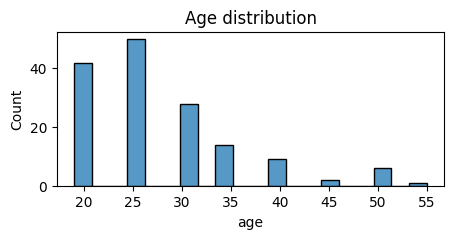

In [37]:
CURRENT_GSE = "GSE30758"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'female',
        'age': int(sample_meta['age']),
        'tissue': 'uterus',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.20. GSE30870

**DNA methylomes of Newborns and Nonagenarians**

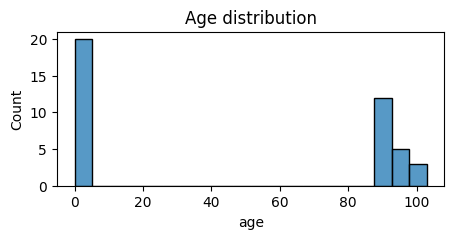

In [38]:
CURRENT_GSE = "GSE30870"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    age = sample_meta['age'].split(' ')[0]
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': None,
        'age': int(age) if age != 'Newborn' else 0,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.21. GSE31848 (CELLS)

In [17]:
CURRENT_GSE = "GSE31848"
gse = get_gse(CURRENT_GSE)

In [18]:
gse.phenotype_data['characteristics_ch1.2.cell type'].value_counts()

characteristics_ch1.2.cell type
Somatic.Tissue                                                                    60
induced pluripotent stem cell, undifferentiated                                   29
Somatic.Primary                                                                   22
embryonic stem cell, undifferentiated                                             19
parthenogentic embryonic stem cell, undifferentiated                               6
Mole                                                                               5
embryonic stem cell, differentiated;spontaneous.day3                               3
induced pluripotent stem cell, differentiated;NeuralProgenitors.day23              3
induced pluripotent stem cell, differentiated;OligodendrocyteProgenitors.day42     2
embryonic stem cell, differentiated;NeuralProgenitors.day22                        2
embryonic stem cell, differentiated;OligodendrocyteProgenitors.day42               1
induced pluripotent stem cell, di

In [19]:
for gsm_name, gsm in gse.gsms.items():
    sample_meta = sample_meta_parse(gsm.metadata)
    cell_type = sample_meta.get('cell type')
    if cell_type is None:
        continue
    if cell_type != 'induced pluripotent stem cell, undifferentiated' and cell_type != 'embryonic stem cell, undifferentiated':
        continue
    if not is_correct_array(gsm):
        continue
    array_cells_save(gsm_name, gsm)
    SAMPLES_CELLS[CURRENT_GSE][gsm_name] = {
        'cell_type': cell_type,
        'platform': get_platform(CURRENT_GSE)
    }

print(f"{len(SAMPLES_CELLS[CURRENT_GSE])} samples saved")
remove_gse(CURRENT_GSE)

48 samples saved


## 1.22. GSE32146

**DNA methylation in a discovery cohort of colon mucosa samples from individuals with Crohns' disease or ulcerative colitis and normal controls**

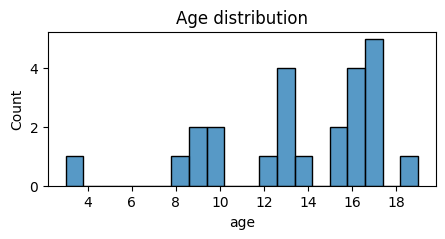

In [39]:
CURRENT_GSE = "GSE32146"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    age = float(sample_meta['age (y)'].split(' ')[0])
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(age),
        'tissue': 'colon',
        'disease': 'healthy' if sample_meta['disease state'] == 'normal' else "Crohn's disease",
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.23. GSE32149

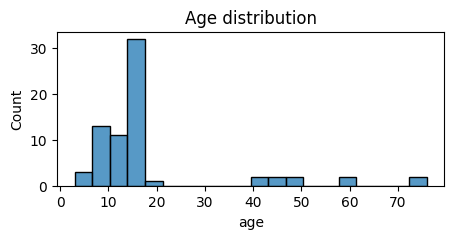

In [40]:
CURRENT_GSE = "GSE32149"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    age = sample_meta['age (y)'].split(' ')[0]
    if age == 'N/A':
        continue
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(float(age)),
        'tissue': 'blood',
        'disease': 'healthy' if sample_meta['disease state'] == 'normal' else "Crohn's disease",
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.24. GSE32393

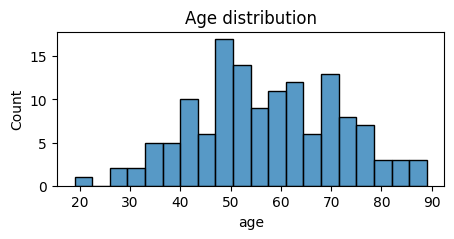

In [41]:
CURRENT_GSE = "GSE32393"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'female',
        'age': int(float(sample_meta['age'])),
        'tissue': 'breast',
        'disease': 'healthy' if sample_meta['status(0=healthy,1=cancer)'] == '0' else 'cancer',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.25. GSE34035

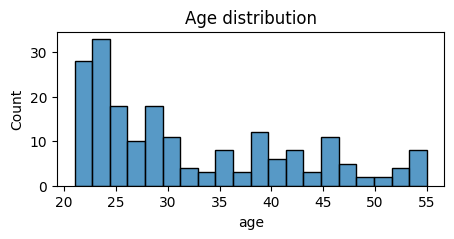

In [42]:
CURRENT_GSE = "GSE34035"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'male' if sample_meta['gender'] == 'M' else 'female',
        'age': int(sample_meta['age']),
        'tissue': 'saliva',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.26. GSE34257

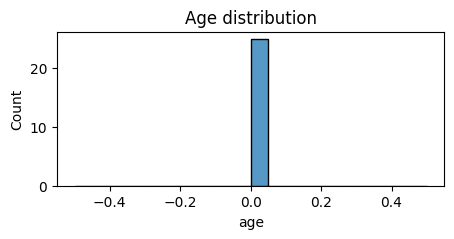

In [43]:
CURRENT_GSE = "GSE34257"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    if sample_meta['tissue'] != 'Peripheral blood':
        continue

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'],
        'age': 0,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.27. GSE34639

In [44]:
CURRENT_GSE = "GSE34639"
gse = get_gse(CURRENT_GSE)

platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'],
        'age': int(sample_meta['age']),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE34639 is 0


## 1.28. GSE35069 (CELLS, BUT NOT EMBRYO)

**Differential DNA Methylation in Purified Human Blood Cells**

## 1.29. GSE36064

**Methylation Profiling of Blood DNA from Healthy Children (Harvard Age Study)**

In [45]:
CURRENT_GSE = "GSE36064"
gse = get_gse(CURRENT_GSE)

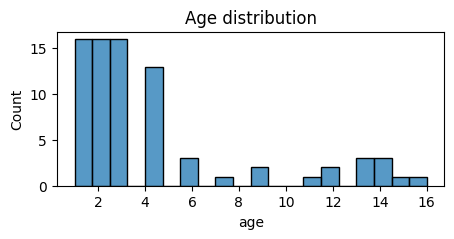

In [46]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'male' if sample_meta['gender'] == 'M' else 'female',
        'age': int(sample_meta['age at collection months']) // 12,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.30. GSE36166 (NO AGE)

**Epigenetic analysis of healthy young men following a control and high-fat overfeeding diet**

## 1.31. GSE36642

**Neonatal DNA methylation profile in humans is specified by a complex interplay between intrauterine environmental/ genetic factors subject to tissue-specific influence**

In [47]:
CURRENT_GSE = "GSE36642"
gse = get_gse(CURRENT_GSE)

In [48]:
(gse.phenotype_data['characteristics_ch1.5.gestational age (wk)'].fillna(0).astype(float) // 12 // 4).value_counts()

characteristics_ch1.5.gestational age (wk)
0.0    123
Name: count, dtype: int64

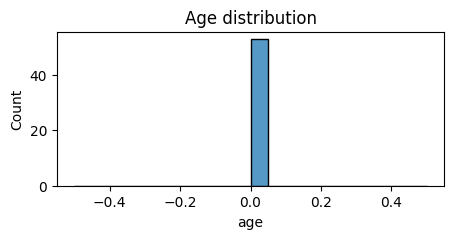

In [49]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    if sample_meta.get('tissue') == 'Placenta':
        continue

    if sample_meta['cell type'] == 'HUVEC':
        continue

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'male' if sample_meta['gender'] == 'M' else 'female',
        'age': 0,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.32. GSE36812

In [50]:
CURRENT_GSE = "GSE36812"
gse = get_gse(CURRENT_GSE)

In [51]:
gse.phenotype_data['characteristics_ch1.3.tissue'].value_counts()

characteristics_ch1.3.tissue
Cord Blood    48
Name: count, dtype: int64

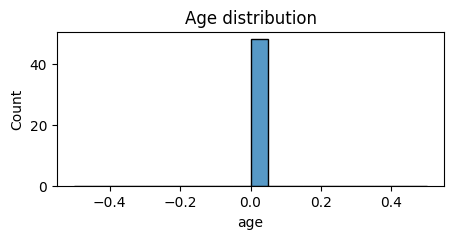

In [52]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)

    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': None,
        'age': 0,
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.33. GSE37008

**Factors underlying variable DNA methylation in a human community cohort**

In [53]:
CURRENT_GSE = "GSE37008"
gse = get_gse(CURRENT_GSE)

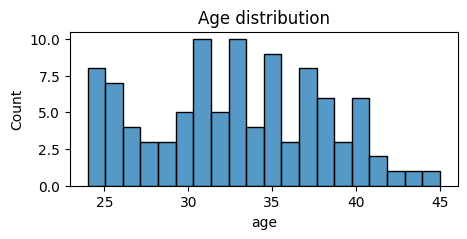

In [54]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['age (y)']),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.34. GSE37066 (CELLS)

**Pluripotent Stem Cells Escape From Senescence-Associated DNA Methylation Changes [Illumina]**

In [20]:
CURRENT_GSE = "GSE37066"
gse = get_gse(CURRENT_GSE)

In [21]:
gse.phenotype_data['characteristics_ch1.1.cell type'].value_counts()

characteristics_ch1.1.cell type
mesenchymal stromal cells (MSC)    10
iPSC                                6
MSC                                 5
Name: count, dtype: int64

In [22]:
for gsm_name, gsm in gse.gsms.items():
    sample_meta = sample_meta_parse(gsm.metadata)
    cell_type = sample_meta.get('cell type')
    
    if cell_type is None:
        continue
    if cell_type != 'iPSC':
        continue
    
    if not is_correct_array(gsm):
        continue

    array_save(gsm_name, gsm)
    SAMPLES_CELLS[CURRENT_GSE][gsm_name] = {
        'cell_type': cell_type,
        'platform': get_platform(CURRENT_GSE)
    }

print(f"{len(SAMPLES_CELLS[CURRENT_GSE])} samples saved")
remove_gse(CURRENT_GSE)

0 samples saved


## 1.35. GSE37988

**Methylation in Taiwanese HCC tumor and adjacent tissues**

In [58]:
CURRENT_GSE = "GSE37988"
gse = get_gse(CURRENT_GSE)

In [59]:
gse.phenotype_data['characteristics_ch1.3.tissue'].value_counts()

characteristics_ch1.3.tissue
liver    62
Name: count, dtype: int64

In [60]:
gse.phenotype_data['characteristics_ch1.2.disease'].value_counts(dropna=False)

characteristics_ch1.2.disease
Hepatocellular carcinoma (HCC)    62
NaN                               62
Name: count, dtype: int64

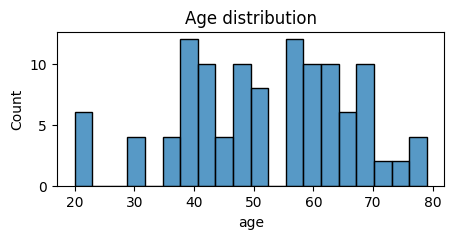

In [61]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)

    age = int(sample_meta['age']) if sample_meta['age'] != 'NA' else None
    if age is None:
        continue
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': age,
        'tissue': sample_meta['tissue'],
        'disease': sample_meta.get('disease', 'healthy'),
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

# 1.36. GSE38291

**Genome-Wide Analysis of DNA Methylation Differences in Muscle and Fat from Monozygotic Twins Discordant for Type 2 Diabetes**

In [62]:
CURRENT_GSE = "GSE38291"
gse = get_gse(CURRENT_GSE)

In [63]:
gse.phenotype_data['source_name_ch1'].value_counts()

source_name_ch1
vastus lateralis muscle        22
subcutaneous adipose tissue    10
Name: count, dtype: int64

In [64]:
gse.phenotype_data['characteristics_ch1.0.type 2 diabetes status'].value_counts()

characteristics_ch1.0.type 2 diabetes status
type 2 diabetic    16
non-diabetic       16
Name: count, dtype: int64

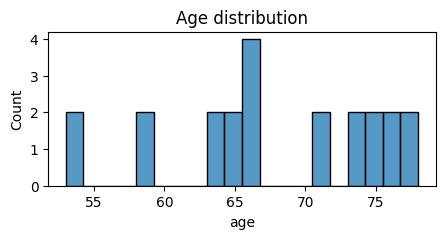

In [65]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    if sample_meta.get('Sex') is None or sample_meta.get('age') is None:
        continue

    tissue = 'muscle' if gsm.metadata['source_name_ch1'][0] == 'vastus lateralis muscle' else 'fat'
    disease = 'healthy' if sample_meta['type 2 diabetes status'] == 'non-diabetic' else 'diabetes II'
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['Sex'].lower(),
        'age': int(sample_meta['age']),
        'tissue': tissue,
        'disease': disease,
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.37. GSE38608

**Brain transcriptional and epigenetic associations with the autistic phenotype (methylation data)**

In [66]:
CURRENT_GSE = "GSE38608"
gse = get_gse(CURRENT_GSE)

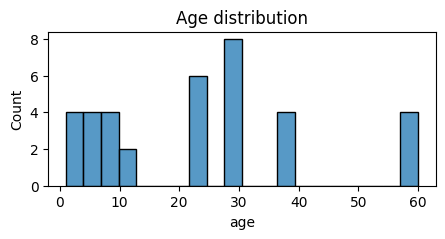

In [67]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': None,
        'age': int(sample_meta['age (years)']),
        'tissue': 'brain',
        'disease': 'healthy' if sample_meta['disease state'] == 'control' else 'autism',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.38. GSE38873 (Skipping because of not exact age)

In [68]:
# CURRENT_GSE = "GSE38873"
# gse = get_gse(CURRENT_GSE)

In [69]:
# platform = get_platform(CURRENT_GSE)
# for gsm_name, gsm in gse.gsms.items():
#     if not is_correct_array(gsm):
#         continue
#     array_save(gsm_name, gsm)

#     sample_meta = sample_meta_parse(gsm.metadata)
    
#     SAMPLES[CURRENT_GSE][gsm_name] = {
#         'sex': None,
#         'age': int(sample_meta['age']),
#         'tissue': sample_meta['tissue'],
#         'disease': 'healthy' if sample_meta['disease state'] == 'Unaffected control' else 'mental',
#         'platform': platform
#     }

# plot_age_ditribution(CURRENT_GSE)
# remove_gse(CURRENT_GSE)

## 1.39. GSE40279

**Genome-wide Methylation Profiles Reveal Quantitative Views of Human Aging Rates**

In [70]:
CURRENT_GSE = "GSE40279"
gse = get_gse(CURRENT_GSE)

In [71]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'female' if sample_meta['gender'] == 'F' else 'male',
        'age': int(sample_meta['age (y)']),
        'tissue': 'blood',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE40279 is 0


## 1.40. GSE40700 (CELLS)

In [30]:
CURRENT_GSE = "GSE40700"
gse = get_gse(CURRENT_GSE)

In [37]:
# Skip because only 1 sample for embryonic stem cell
gse.phenotype_data['characteristics_ch1.6.cell description'].value_counts()

characteristics_ch1.6.cell description
B-lymphocyte, lymphoblastoid, International HapMap Project, CEPH/Utah pedigree 1463, treatment: Epstein-Barr Virus transformed                                                                                   2
embryonic stem cells                                                                                                                                                                                             1
acute megakaryocytic leukemia cells, "established from the peripheral blood of a 10-month-old boy with Down's syndrome and acute megakaryocytic leukemia (AML M7) at relapse in 1985" - DSMZ. (PMID: 3016165)    1
choroid plexus epithelial cells                                                                                                                                                                                  1
cardiac myocytes                                                                                                     

## 1.41. GSE41037

**Aging effects on DNA methylation modules in blood tissue**

In [72]:
CURRENT_GSE = "GSE41037"
gse = get_gse(CURRENT_GSE)

In [73]:
gse.phenotype_data['characteristics_ch1.3.tissue'].value_counts()

characteristics_ch1.3.tissue
whole blood    720
Name: count, dtype: int64

In [74]:
gse.phenotype_data['characteristics_ch1.2.diseasestatus'].value_counts()

characteristics_ch1.2.diseasestatus
1; control                  394
2; schizophrenia patient    325
3; bipolar patient            1
Name: count, dtype: int64

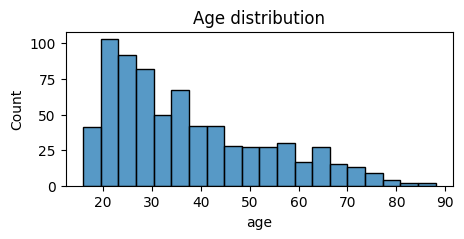

In [75]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    disease = sample_meta['diseasestatus'].split('; ')[1]
    if disease == 'control':
        disease = 'healthy'
    elif disease == 'schizophrenia patient':
        disease = 'shizophrenia'
    elif disease == 'bipolar patient':
        disease = 'bipolar'
    else:
        raise ValueError(f"Unknown disease: {disease}")
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'],
        'age': int(sample_meta['age']),
        'tissue': 'blood',
        'disease': disease,
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.42. GSE41169

**Blood DNA methylation profiles in a Dutch population**

In [76]:
CURRENT_GSE = "GSE41169"
gse = get_gse(CURRENT_GSE)

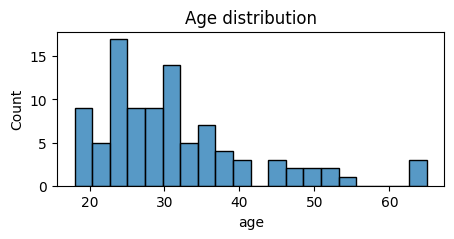

In [77]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'].lower(),
        'age': int(sample_meta['age']),
        'tissue': 'blood',
        'disease': 'healthy' if sample_meta['diseasestatus (1=control, 2=scz patient)'] == '1' else 'shizophrenia',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.43. GSE41782 (NOT HUMANS)

**A genome-wide comparative study of DNA methylation in great apes**

## 1.44. GSE41826

**A Cell Epigenotype Specific Model for the Correction of Cellular Heterogeneity in the Brain**

In [78]:
CURRENT_GSE = "GSE41826"
gse = get_gse(CURRENT_GSE)

In [79]:
gse.phenotype_data['characteristics_ch1.1.diagnosis'].value_counts()

characteristics_ch1.1.diagnosis
Control       77
Depression    68
Name: count, dtype: int64

In [80]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['Sex'].lower(),
        'age': int(sample_meta['age']),
        'tissue': 'brain',
        'disease': 'healthy' if sample_meta['diagnosis'] == 'Control' else 'depression',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE41826 is 0


## 1.45. GSE42510 (NO AGE)

## 1.46. GSE42700

**Epigenome analysis of buccal cells from monozygotic and dizygotic twins**

In [90]:
CURRENT_GSE = "GSE42700"
gse = get_gse(CURRENT_GSE)

In [91]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': sample_meta['gender'],
        'age': 0 if sample_meta['age'] == 'birth' else int(sample_meta['age'].split(' ')[0]) // 12,
        'tissue': 'skin',
        'disease': 'healthy',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

The length of GSE42700 is 0


## 1.47. GSE42861

**Differential DNA methylation in Rheumatoid arthritis**

In [83]:
CURRENT_GSE = "GSE42861"
gse = get_gse(CURRENT_GSE)

In [86]:
gse.phenotype_data['characteristics_ch1.1.disease state'].value_counts()

characteristics_ch1.1.disease state
rheumatoid arthritis    354
Normal                  335
Name: count, dtype: int64

In [88]:
gse.phenotype_data['characteristics_ch1.0.cell type'].value_counts()

characteristics_ch1.0.cell type
PBL    689
Name: count, dtype: int64

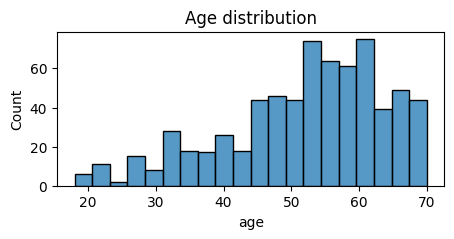

In [89]:
platform = get_platform(CURRENT_GSE)
for gsm_name, gsm in gse.gsms.items():
    if not is_correct_array(gsm):
        continue
    array_save(gsm_name, gsm)

    sample_meta = sample_meta_parse(gsm.metadata)
    
    SAMPLES[CURRENT_GSE][gsm_name] = {
        'sex': 'female' if sample_meta['gender'] == 'f' else 'male',
        'age': int(sample_meta['age']),
        'tissue': 'blood',
        'disease': 'healthy' if sample_meta['disease state'] != 'rheumatoid arthritis' else 'rheumatoid arthritis',
        'platform': platform
    }

plot_age_ditribution(CURRENT_GSE)
remove_gse(CURRENT_GSE)

## 1.48. GSE42865 (NO AGE)

## 1.49. GSE43269 (NO AGE)

## 1.50. GSE44667 (NO AGE)

## 1.51. GSE47627 (NO AGE)

## Gather Samples

In [92]:
samples_list = []
for gse_id, samples in SAMPLES.items():
    for sample_id, sample in samples.items():
        samples_list.append({
            'GSE': gse_id,
            'Sample': sample_id,
            **sample
        })
samples_df = pd.DataFrame(samples_list)
samples_df

,GSE,Sample,sex,age,tissue,disease,platform
0,GSE15745,GSM401538,male,20,brain,healthy,27k
1,GSE15745,GSM401539,male,44,brain,healthy,27k
2,GSE15745,GSM401540,male,68,brain,healthy,27k
3,GSE15745,GSM401541,male,38,brain,healthy,27k
4,GSE15745,GSM401542,male,66,brain,healthy,27k
...,...,...,...,...,...,...,...
4721,GSE42861,GSM1052209,female,63,blood,healthy,450k
4722,GSE42861,GSM1052210,female,63,blood,healthy,450k
4723,GSE42861,GSM1052211,female,46,blood,healthy,450k
4724,GSE42861,GSM1052212,female,64,blood,healthy,450k


In [93]:
samples_df['platform'].value_counts()

platform
27k     3730
450k     996
Name: count, dtype: int64

In [94]:
samples_df['tissue'].value_counts()

tissue
blood          3268
brain           542
saliva          281
prostate        155
uterus          152
breast          137
liver           114
colon            24
muscle           22
bone marrow      16
skin             15
Name: count, dtype: int64

In [95]:
samples_df['disease'].value_counts()

disease
healthy                           3174
cancer                             473
shizophrenia                       387
rheumatoid arthritis               354
diabetes I                         195
Hepatocellular carcinoma (HCC)      57
Crohn's disease                     55
autism                              19
diabetes II                         11
bipolar                              1
Name: count, dtype: int64

In [96]:
samples_df.to_csv("data/geo_samples.csv", index=False)

In [25]:
cell_samples_list = []
for gse_id, samples in SAMPLES_CELLS.items():
    for sample_id, sample in samples.items():
        cell_samples_list.append({
            'GSE': gse_id,
            'Sample': sample_id,
            **sample
        })
cell_samples_df = pd.DataFrame(cell_samples_list)
cell_samples_df.loc[cell_samples_df['cell_type'].str.contains('pluripotent'), 'cell_type'] = 'iPSC'
cell_samples_df.loc[cell_samples_df['cell_type'].str.contains('embryonic'), 'cell_type'] = 'ESC'
cell_samples_df

,GSE,Sample,cell_type,platform
0,GSE30090,GSM744663,ESC,27k
1,GSE30090,GSM744664,ESC,27k
2,GSE30090,GSM744665,ESC,27k
3,GSE30090,GSM744666,ESC,27k
4,GSE30090,GSM744667,ESC,27k
...,...,...,...,...
231,GSE31848,GSM867991,iPSC,450k
232,GSE31848,GSM867992,iPSC,450k
233,GSE31848,GSM867993,iPSC,450k
234,GSE31848,GSM867994,iPSC,450k


In [26]:
cell_samples_df['cell_type'].value_counts()

cell_type
ESC     160
iPSC     76
Name: count, dtype: int64

In [27]:
# Save cell samples
cell_samples_df.to_csv("data/geo_cell_samples.csv", index=False)
